# Imports

In [4]:
import numpy as np
#import pyaudio
import time
import matplotlib.pyplot as plt
%matplotlib inline

import essentia
# there are 2 operating modes in essentia which have the same algorithms:
import essentia.standard
import essentia.streaming

import madmom as mad

# Process data sets

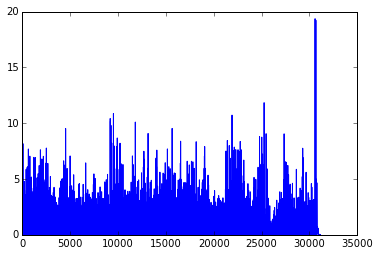

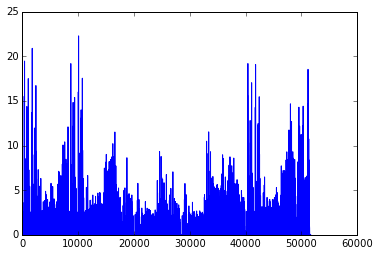

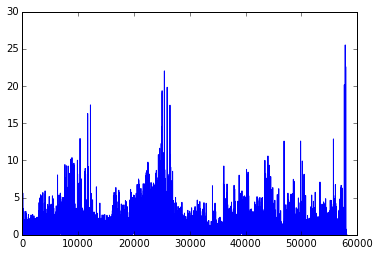

In [18]:
# folds used in article N

#url = 'http://www.eecs.qmul.ac.uk/~sss31/TASLP/'

dat_dir = 'data/maps/'
train_fn = ['debug.txt', 'train1.txt', 'train2.txt', 'train3.txt', 'train4.txt']
test_fn = ['test1.txt', 'test2.txt', 'test3.txt', 'test4.txt']

for i in range(1): # range(len(train_fn)
    
    # create train data structure. don't think you want continuous string b/c y times have to match
    train_x = []; train_y = []; test_x = []; test_y = []
    
    for line in open(dat_dir + train_fn[i], 'U'):  # opened in text-mode; all EOLs are converted to '\n'
        line = line.rstrip('\n')
        
        # append Essentia or Madmom objects w/ x parms, .wav duration
        train_x.append(wave_to_x(dat_dir, line))
        
        #train_y.append(txt_to_y(dat_dir, train_fld[j], train_x[j].wav_dur)
        
        # save essentia object under trainfile name
        
    #for line in open(dat_dir + test_fn[i], 'U'):  # opened in text-mode; all EOLs are converted to '\n'
    #    line = line.rstrip('\n')
            
    #    test_x.append(wave_to_x(dat_dir, line))
        
        #test_y.append(txt_to_y(dat_dir, test_fld[j], test_x[j].wav_dur)
        
        # save essentia object under trainfile name
        
    # now you've got these objects. you need to chunk through them feeding variables to nets then integrating nets 

# wav-to-x

In [16]:
from scipy.ndimage.filters import maximum_filter

#fps = TBD
#frm_rt = 1 / fps

def wave_to_x(wav_dir, wav_file):

    log_filt_spec = mad.audio.spectrogram.LogarithmicFilteredSpectrogram(wav_dir + wav_file,
                                                                         num_channels=1,
                                                                         num_bands=48)
    
    superflux = mad.features.onsets.superflux(log_filt_spec)
    plt.figure(), plt.plot(superflux)
    
    # PROBLEM:
    # 1. IS LOG FILTERED SPECTROGRAM AN ABSOLUTE (ACROSS SAMPLES) OR RELATIVE (W/IN SAMPLE) SCALE
    # 2. Is max pitch sufficient for identifying notes, chords?
    
    # wave form
    # duration
    
    return(superflux)
    

(31141,)

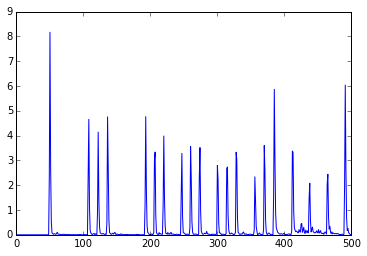

In [41]:
plt.plot(train_x[0][:500])
train_x[0].shape

In [42]:
train_x[0]

AttributeError: 'SpectrogramDifference' object has no attribute 'sample_rate'

# txt-to-y

In [ ]:
# open / read text file
# create y vect of zeros of len wav_dur / frm_rt
# iterate thru lines
    # onset detection: flip 1's from onset to offset
    # pitch detection: 88 notes? 88 notes + chords? Or, train it to flip multiple 1's for chords. 
        # while best is only 88 (flipping more than one), think softmax assumes mutually exclusive
    
    

how do you spot notes vs. echos vs. chords?
if you feed frames at 44100 hz, does it learn to recognize c# by its peak spectrum profile? or can it spot that as it develops frame by frame?

is it more efficient to run an onset / offset identifier (network or other) first to pull out the sounds and feed them to the network? 

how do you encode y? they've put down the onset and offset times. 
1. if you encode y=1 for all frames during that period, you're hoping it can spot the tone on the way up and down. that suggests a multi-frame CNN or a LSTM. theoretically, it could try to predict for every frame. but on way down lots of notes look the same. so, confidence s/b low and you'd not predict (default 0). 

2. if you think it's just going to find it based on relative peaks, take start time + 100ms

3. at 47kHz you're getting 800 frames / second. that's a lot. maybe sample less to get rougher image. train acustic model less and use song model to bring up accuracy i.e., taking output from last hidden nodes for acustic and song models 

READ HER ORIGINAL PIECE, THE OTHER ONE THAT USED HERS AND/OR THE ONE THAT MENTIONED 

1. if you have onset identifier,it needs to be an array of 0's as long as x. then at the time stamp, it needs to be incoded w/ the midi pitch? then you need to translate to the note

In [ ]:
for ds in datasets:
    
    # LogarithmicFilteredSpectrogram class accepts STFT, FramedSignal, Signal object or a file name as input.
    # It loads, filters and scales.

    log_filt_spec2 = mad.audio.spectrogram.LogarithmicFilteredSpectrogram('data/maps/MAPS_AkPnBcht_1/AkPnBcht/ISOL/CH/MAPS_ISOL_CH0.1_F_AkPnBcht.wav',
                                                                      num_channels=1,
                                                                      num_bands=24)
    
    log_filt_spec = mad.audio.spectrogram.LogarithmicFilteredSpectrogram(ds,
                                                                         num_channels=1,
                                                                         num_bands=24)

    # SpectrogramDifference class calculates first order difference of a spectrogram. diff_frames sets the number
    # of frames how far apart the difference should be calculated. diff_max_bins performs maximum filtering. Or, 
    # positive_diffs returns only the positive differences. Resulting diff spectrogram has the same shape as the 
    # given one (np.diff() does not), with all frames < diff_frames set to zero.

    superflux_diff = mad.audio.spectrogram.SpectrogramDifference(log_filt_spec, positive_diffs=True, diff_max_bins=3)

    superflux_2 = np.sum(superflux_diff, axis=1)

    superflux_3 = mad.features.onsets.superflux(log_filt_spec)

    # we scale them to have the same range
    plt.figure()
    plt.plot(sf1 / sf1.max(), 'b')  # blue
    plt.plot(superflux1 / superflux1.max(), 'g')  # green
    plt.plot(superflux_2_1 / superflux_2_1.max(), 'r--')  # dashed red
    plt.plot(superflux_3_1 / superflux_3_1.max(), 'k:')  # dotted black


# Read

1. Files from directory, OR
2. Stream

# V1: Import piano train / test data

1. Take their lists of train and test data
2. Create list object
3. Feed it to a process to either iteratively or bulk load files from directory
4. Perform log scale transform of input wav
5. Come back to other features, chords


# Learn to map sound to notes

1. Take professional music sound files
2. Play, logging spectrum (frequency / time) and other attributes
    a. https://github.com/tyiannak/pyAudioAnalysis/wiki/3.-Feature-Extraction, OR
    b. 
3. Predict notes based on sound
    a. input spectrum is the "X"
    b. sheet music notes are the "y" (notes A, B, C, etc.)

# V1: Generate harp note / chord train / test files

Garageband or other to generate:
1. individual instrument note (pitch?), chord by major/minor, octave, inversion
2. sequence files w/ varying amounts of spacing
3. mp3's of classical music for which you can easily veryify the notes


# V2: Standard: Fingerprint music files

In [ ]:
# use FFT, MFCC, etc to create a fignerprint of each of the music files s/t when user starts playing, you can take notes they've played and match 

# V2: Streaming: Extract note Sample

# V2: Streaming: Search / match sample to fingerprints

# Establish stream

Use pyaudio to instantiate stream for practice session

In [ ]:
WIDTH = 2
CHANNELS = 2
RATE = 44100

p = pyaudio.PyAudio()

def callback(in_data, frame_count, time_info, status):
    return (in_data, pyaudio.paContinue)

stream = p.open(format=p.get_format_from_width(WIDTH),
                channels=CHANNELS,
                rate=RATE,
                input=True,
                output=True,
                stream_callback=callback)

stream.start_stream()

while stream.is_active():
    time.sleep(0.1)

stream.stop_stream()
stream.close()

p.terminate()

# Display mode

1. Accept song selection
2. Load / display sheet music
3. Listen for start
4. Recieve sounds / translate notes
5. Track progress w/ vertical bar
6. Spot repeats re-setting tracking bar

In [ ]:
# https://github.com/tyiannak/pyAudioAnalysis
# http://essentia.upf.edu/documentation/


# Evaluate mode

1. display mode functionality including tracking progress
2. record playing. overlay repeats. you're tracking stats. so, obj s/b:
    a. to get through song re-playing pieces as required, THEN
    b. to get through song cleanly
3. comparing played to professional
    a. option to play:
        i. metrinome 
        ii. professional a low volume
4. identify discrpancies (timing after prior note, incorrect note)
    a. Gaia, a C++ library with python bindings which implement similarity measures and classification on the results of audio analysis, and generate classification models that Essentia can use to compute high-level description of music.
5. show discrepancies
    a. accept tolerances (+/- time, other?)
    b. show played note in red (i.e., before/after, above/below).
6. show / log statistics
    a. accuracy
    b. similarity
    c. error types and frequency distribution
        i. early,
        ii. late
        iii. wrong note
    d. problem areas

# Interactive mode

1. evaluate mode functionality
2. prompt session info and imprint voice of user for command interface
    a. "this is []. the date is []. i'll be practicing for about [] minutes."
3. voice commands
    a. "replay [] notes" - defaults to: 5 notes, played version
    b. "replay base [] notes"
    c. "loop [] notes" - 
        ii. Loop [] notes / Stop Loop
2. 

# References

This project would not be possible without the invaluable assistance of:

## Training data

The MAPS piano data set. Roughly 40G of piano notes, chords, music assembled by V. Emiya for her PhD thesis at Telecom ParisTech/ENST in 2008 and in conjunction with R. Badeau, B. David for their paper "Multipitch estimation of piano sounds using a new probabilistic spectral smoothness principle"<cite data-cite="emiya2010multipitch"></cite>


In [ ]:
# for installing latex, bibtex and pdf-ing jupyter notenooks: https://www.youtube.com/watch?v=m3o1KXA1Rjk